In [ ]:
import cv2
import pandas as pd
import numpy as np
from sklearn.utils import resample
import os
import glob
import torch
import torch.nn as nn
from torchvision.utils import make_grid
from collections import OrderedDict
from PIL import Image
import matplotlib.pyplot as plt
from torchvision import transforms, models
from torchvision.models import resnet50, ResNet50_Weights
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

### **Load the Dataset**

In [ ]:
!wget "https://isic-challenge-data.s3.amazonaws.com/2018/ISIC2018_Task3_Training_GroundTruth.zip"
!wget "https://isic-challenge-data.s3.amazonaws.com/2018/ISIC2018_Task3_Training_Input.zip"
!wget "https://isic-challenge-data.s3.amazonaws.com/2018/ISIC2018_Task3_Validation_GroundTruth.zip"
!wget "https://isic-challenge-data.s3.amazonaws.com/2018/ISIC2018_Task3_Validation_Input.zip"
!wget "https://isic-challenge-data.s3.amazonaws.com/2018/ISIC2018_Task3_Test_Input.zip"
!wget "https://isic-challenge-data.s3.amazonaws.com/2018/ISIC2018_Task3_Test_GroundTruth.zip"

--2024-04-07 08:17:26--  https://isic-challenge-data.s3.amazonaws.com/2018/ISIC2018_Task3_Training_GroundTruth.zip
Resolving isic-challenge-data.s3.amazonaws.com (isic-challenge-data.s3.amazonaws.com)... 52.216.78.108, 3.5.28.150, 16.182.71.113, ...
Connecting to isic-challenge-data.s3.amazonaws.com (isic-challenge-data.s3.amazonaws.com)|52.216.78.108|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 36681 (36K) [application/zip]
Saving to: ‘ISIC2018_Task3_Training_GroundTruth.zip’

ISIC2018_Task3_Trai 100%[===================>]  35.82K  --.-KB/s    in 0.03s   

2024-04-07 08:17:26 (1.27 MB/s) - ‘ISIC2018_Task3_Training_GroundTruth.zip’ saved [36681/36681]

--2024-04-07 08:17:26--  https://isic-challenge-data.s3.amazonaws.com/2018/ISIC2018_Task3_Training_Input.zip
Resolving isic-challenge-data.s3.amazonaws.com (isic-challenge-data.s3.amazonaws.com)... 52.216.78.108, 3.5.28.150, 16.182.71.113, ...
Connecting to isic-challenge-data.s3.amazonaws.com (isic-challenge

In [ ]:
!unzip ISIC2018_Task3_Training_Input
!unzip ISIC2018_Task3_Training_GroundTruth
!unzip ISIC2018_Task3_Validation_Input
!unzip ISIC2018_Task3_Validation_GroundTruth
!unzip ISIC2018_Task3_Test_Input
!unzip ISIC2018_Task3_Test_GroundTruth

Streaming output truncated to the last 5000 lines.
  inflating: ISIC2018_Task3_Training_Input/ISIC_0031050.jpg  
 extracting: ISIC2018_Task3_Training_Input/ISIC_0031051.jpg  
 extracting: ISIC2018_Task3_Training_Input/ISIC_0031052.jpg  
 extracting: ISIC2018_Task3_Training_Input/ISIC_0031053.jpg  
 extracting: ISIC2018_Task3_Training_Input/ISIC_0031054.jpg  
 extracting: ISIC2018_Task3_Training_Input/ISIC_0031055.jpg  
  inflating: ISIC2018_Task3_Training_Input/ISIC_0031056.jpg  
 extracting: ISIC2018_Task3_Training_Input/ISIC_0031057.jpg  
  inflating: ISIC2018_Task3_Training_Input/ISIC_0031058.jpg  
  inflating: ISIC2018_Task3_Training_Input/ISIC_0031059.jpg  
  inflating: ISIC2018_Task3_Training_Input/ISIC_0031060.jpg  
 extracting: ISIC2018_Task3_Training_Input/ISIC_0031061.jpg  
  inflating: ISIC2018_Task3_Training_Input/ISIC_0031062.jpg  
 extracting: ISIC2018_Task3_Training_Input/ISIC_0031063.jpg  
  inflating: ISIC2018_Task3_Training_Input/ISIC_0031064.jpg  
  inflating: ISIC20

In [ ]:
train_df = pd.read_csv('/content/ISIC2018_Task3_Training_GroundTruth/ISIC2018_Task3_Training_GroundTruth.csv')
classes = train_df.columns[1:]
train_df['label'] = train_df.iloc[:, 1:].idxmax(axis=1)

validation_df = pd.read_csv('/content/ISIC2018_Task3_Validation_GroundTruth/ISIC2018_Task3_Validation_GroundTruth.csv')
validation_df['label'] = validation_df.iloc[:, 1:].idxmax(axis=1)

test_df = pd.read_csv('/content/ISIC2018_Task3_Test_GroundTruth/ISIC2018_Task3_Test_GroundTruth.csv')
test_df['label'] = test_df.iloc[:, 1:].idxmax(axis=1)

train_image_directory = '/content/ISIC2018_Task3_Training_Input'
valid_image_directory = '/content/ISIC2018_Task3_Validation_Input'
test_image_directory = '/content/ISIC2018_Task3_Test_Input'

In [ ]:
#combine train and validation datasets and divide them as 80% and 20%
from sklearn.model_selection import train_test_split
concatenated_dataset = pd.concat([train_df, validation_df])
train_df, validation_df = train_test_split(concatenated_dataset, test_size=0.20, random_state=42)

In [ ]:
label_to_idx = {label: idx for idx, label in enumerate(train_df.iloc[:, 1:].columns)}
train_df['label_idx'] = train_df['label'].map(label_to_idx)
train_df

image  MEL   NV  BCC  AKIEC  BKL   DF  VASC  label  label_idx
3795  ISIC_0028101  0.0  1.0  0.0    0.0  0.0  0.0   0.0     NV          1
6537  ISIC_0030843  1.0  0.0  0.0    0.0  0.0  0.0   0.0    MEL          0
5009  ISIC_0029315  0.0  0.0  0.0    1.0  0.0  0.0   0.0  AKIEC          3
5914  ISIC_0030220  0.0  1.0  0.0    0.0  0.0  0.0   0.0     NV          1
9538  ISIC_0033844  0.0  0.0  0.0    0.0  0.0  0.0   1.0   VASC          6
...            ...  ...  ...  ...    ...  ...  ...   ...    ...        ...
5734  ISIC_0030040  0.0  1.0  0.0    0.0  0.0  0.0   0.0     NV          1
5191  ISIC_0029497  0.0  1.0  0.0    0.0  0.0  0.0   0.0     NV          1
5390  ISIC_0029696  0.0  1.0  0.0    0.0  0.0  0.0   0.0     NV          1
860   ISIC_0025166  0.0  1.0  0.0    0.0  0.0  0.0   0.0     NV          1
7270  ISIC_0031576  0.0  1.0  0.0    0.0  0.0  0.0   0.0     NV          1

[8166 rows x 10 columns]

In [ ]:
label_to_idx = {label: idx for idx, label in enumerate(validation_df.iloc[:, 1:].columns)}
validation_df['label_idx'] = validation_df['label'].map(label_to_idx)
validation_df

image  MEL   NV  BCC  AKIEC  BKL   DF  VASC label  label_idx
5062  ISIC_0029368  0.0  1.0  0.0    0.0  0.0  0.0   0.0    NV          1
2405  ISIC_0026711  0.0  1.0  0.0    0.0  0.0  0.0   0.0    NV          1
9478  ISIC_0033784  0.0  0.0  0.0    0.0  1.0  0.0   0.0   BKL          4
8713  ISIC_0033019  0.0  0.0  1.0    0.0  0.0  0.0   0.0   BCC          2
9085  ISIC_0033391  0.0  0.0  0.0    0.0  1.0  0.0   0.0   BKL          4
...            ...  ...  ...  ...    ...  ...  ...   ...   ...        ...
7464  ISIC_0031770  0.0  0.0  0.0    0.0  1.0  0.0   0.0   BKL          4
4248  ISIC_0028554  0.0  1.0  0.0    0.0  0.0  0.0   0.0    NV          1
8920  ISIC_0033226  1.0  0.0  0.0    0.0  0.0  0.0   0.0   MEL          0
2388  ISIC_0026694  1.0  0.0  0.0    0.0  0.0  0.0   0.0   MEL          0
7471  ISIC_0031777  0.0  1.0  0.0    0.0  0.0  0.0   0.0    NV          1

[2042 rows x 10 columns]

In [ ]:
label_to_idx = {label: idx for idx, label in enumerate(test_df.iloc[:, 1:].columns)}
test_df['label_idx'] = test_df['label'].map(label_to_idx)
test_df.tail()

image  MEL   NV  BCC  AKIEC  BKL   DF  VASC  label  label_idx
1507  ISIC_0036060  0.0  0.0  0.0    0.0  1.0  0.0   0.0    BKL          4
1508  ISIC_0036061  0.0  1.0  0.0    0.0  0.0  0.0   0.0     NV          1
1509  ISIC_0036062  0.0  0.0  0.0    1.0  0.0  0.0   0.0  AKIEC          3
1510  ISIC_0036063  0.0  0.0  0.0    0.0  1.0  0.0   0.0    BKL          4
1511  ISIC_0036064  0.0  0.0  1.0    0.0  0.0  0.0   0.0    BCC          2

### **Exploratory Data Analysis (EDA)**

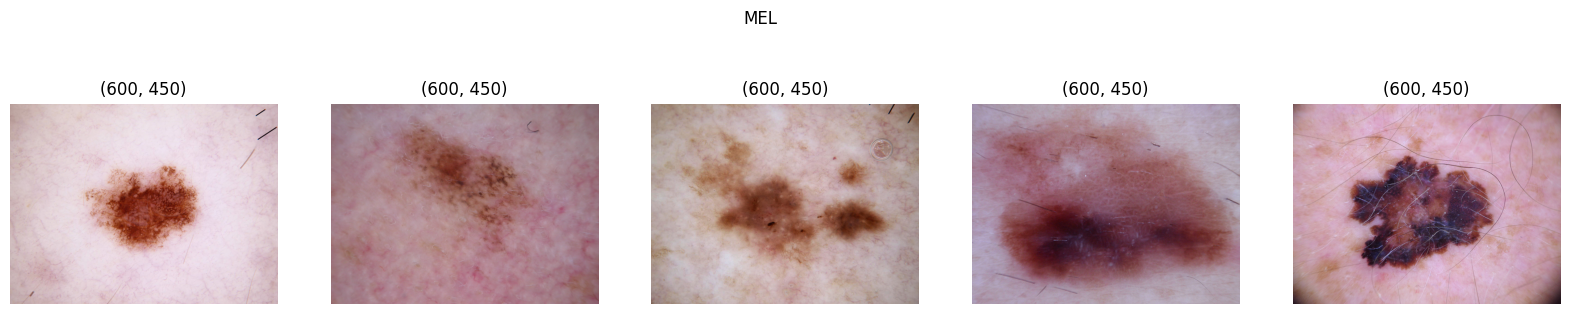

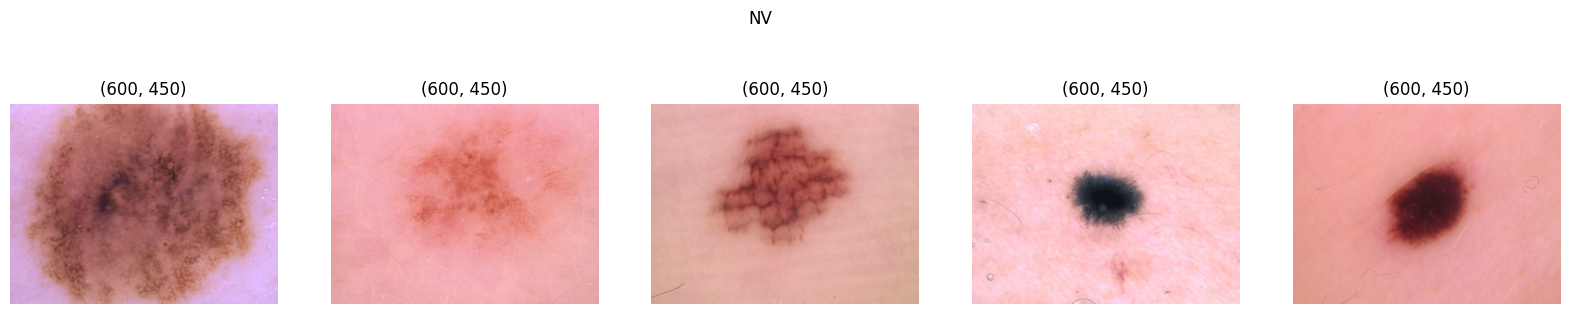

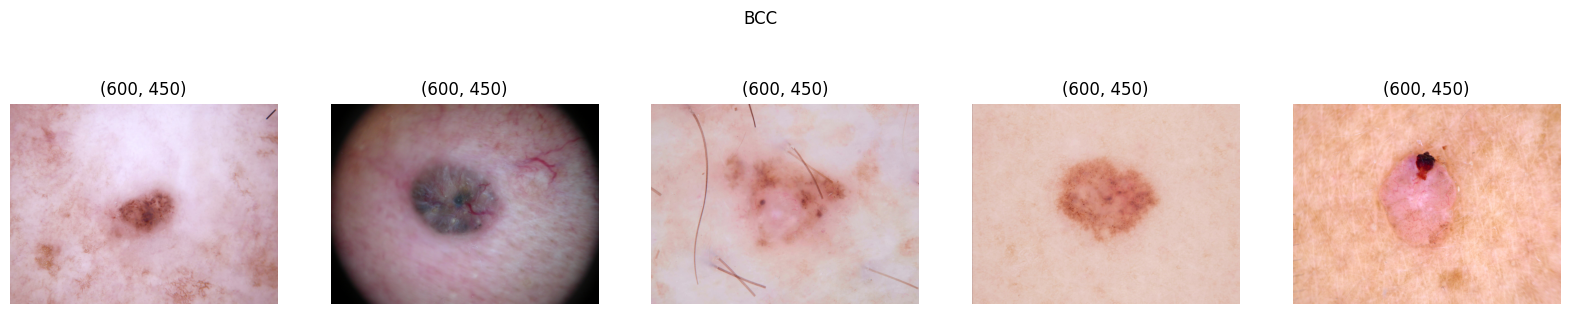

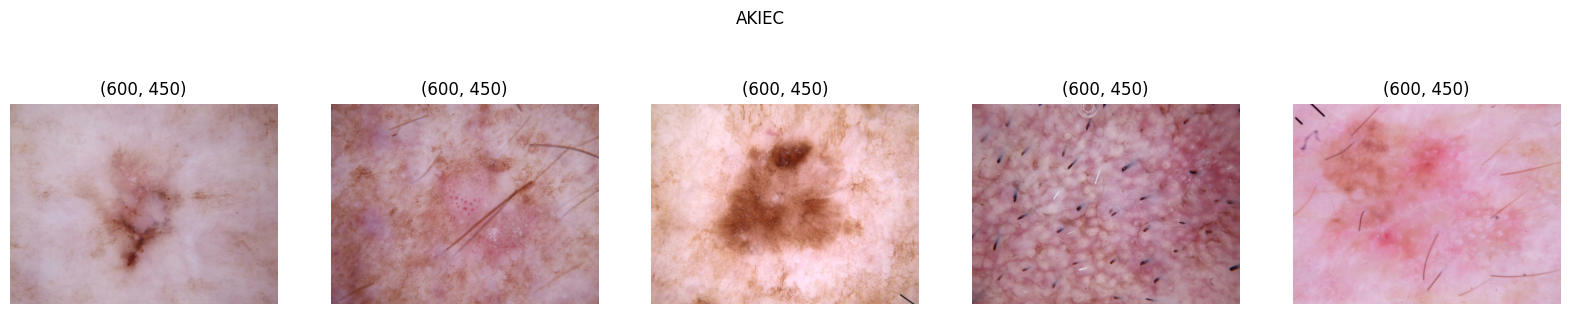

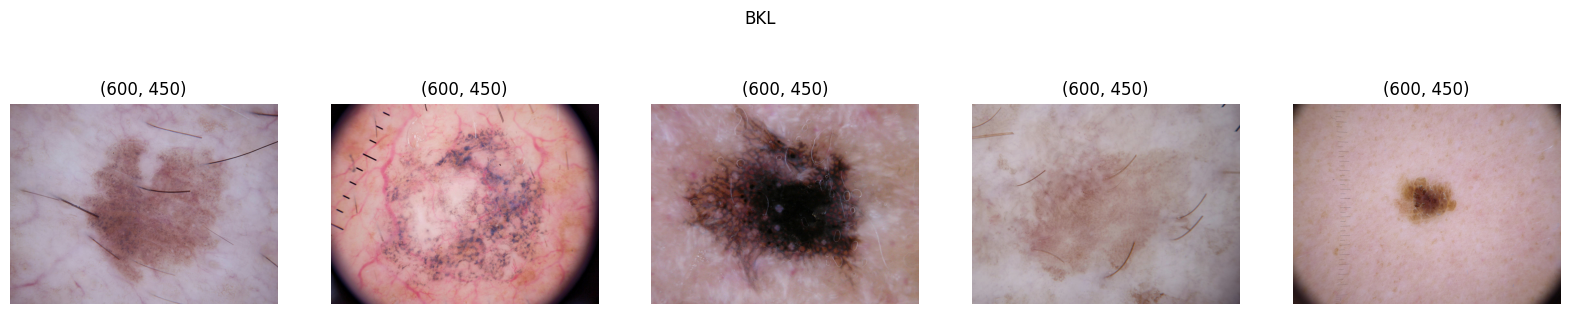

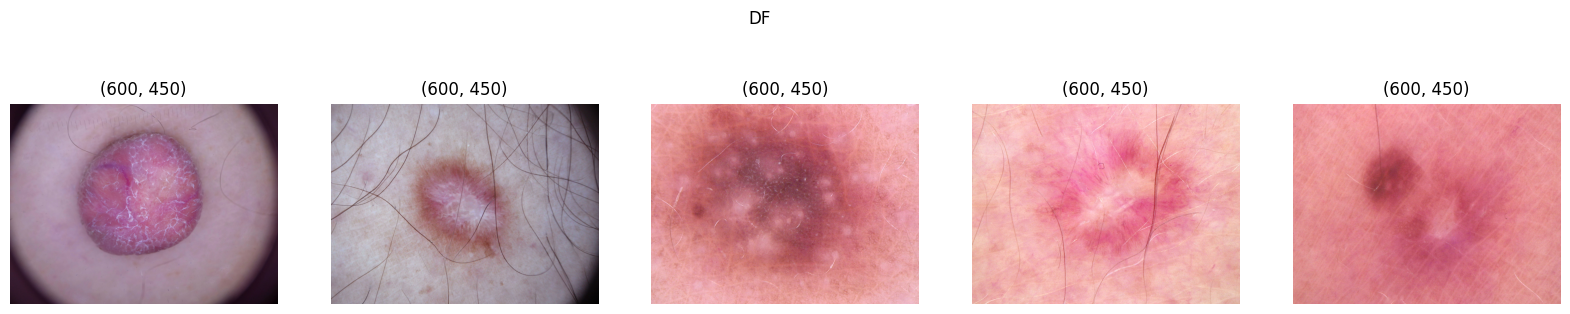

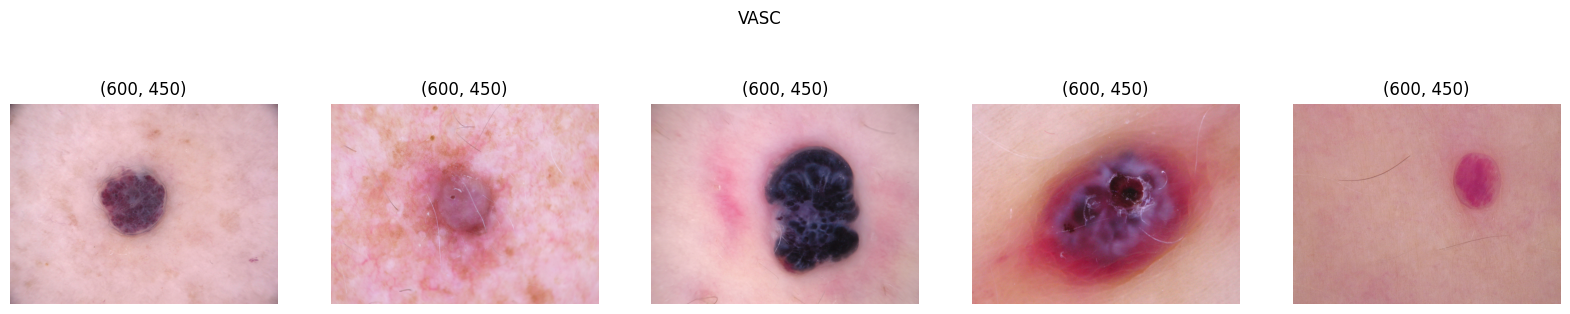

In [ ]:
def plot_data(data):
    # Display 5 images from each class
    for class_name in classes:
        # Filter the DataFrame to get 5 image names for the current class
        class_images = data[data[class_name] == 1.0]['image'].values[:5]
        # Create a subplot for each class
        fig, axs = plt.subplots(1, 5, figsize=(20, 4))
        fig.suptitle(class_name)
        image_sizes = []
        for i, image_name in enumerate(class_images):
            image_path = os.path.join(train_image_directory, image_name + '.jpg')
            image = Image.open(image_path)
            axs[i].imshow(image)
            axs[i].axis('off')  # Hide the axis
            axs[i].set_title(f'\n{image.size}')

        plt.show()
plot_data(train_df)

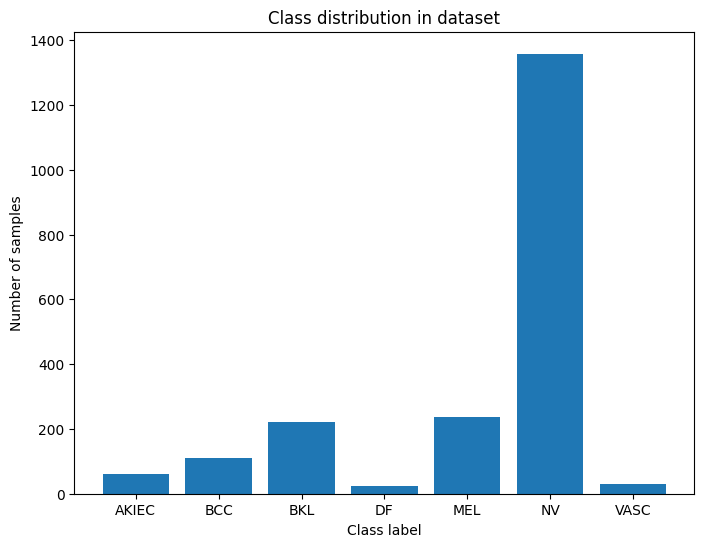

In [ ]:
# check Class distribution in dataset
unique_labels, counts = np.unique(validation_df['label'], return_counts=True)
plt.figure(figsize=(8, 6))
plt.bar(unique_labels, counts)
plt.xlabel('Class label')
plt.ylabel('Number of samples')
plt.title('Class distribution in dataset')
plt.show()

### **Data Augmentation**

In [ ]:
# Load train dataset
train_df['image_path'] = train_df['image'].apply(lambda x: os.path.join(train_image_directory, x + '.jpg'))

# Filter out rows with images that do not exist
train_df = train_df[train_df['image_path'].apply(os.path.isfile)]

# Load validation dataset
validation_df['image_path'] = validation_df['image'].apply(lambda x: os.path.join(valid_image_directory, x + '.jpg'))

# Filter out rows with images that do not exist
validation_df = validation_df[validation_df['image_path'].apply(os.path.isfile)]

# Load test dataset
test_df['image_path'] = test_df['image'].apply(lambda x: os.path.join(test_image_directory, x + '.jpg'))

# Filter out rows with images that do not exist
test_df = test_df[test_df['image_path'].apply(os.path.isfile)]

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(0.5),
    transforms.RandomRotation(degrees=180),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406),  (0.229, 0.224, 0.225)),
])

# Define a custom dataset class
class CustomImageDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.df = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_path = self.df.iloc[idx]['image_path']
        image = Image.open(img_path).convert('RGB')
        label = self.df.iloc[idx]['label_idx']

        if self.transform:
            image = self.transform(image)

        return image, label

# Create an instance of the custom dataset
train_dataset = CustomImageDataset(train_df, transform=transform)
val_dataset = CustomImageDataset(validation_df, transform=transform)
test_dataset = CustomImageDataset(test_df, transform=transform)

# # Create a data loader
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)

In [ ]:
# class_counts = {}

# # Iterating through batches in the train_loader
# for _, labels in train_loader:
#     for label in labels:
#         if label.item() in class_counts:
#             class_counts[label.item()] += 1
#         else:
#             class_counts[label.item()] = 1

# # Display the counts
# print("Class distribution in the train_loader:")
# for class_id, count in class_counts.items():
#     print(f"Class {class_id}: {count}")

In [ ]:
stats = ((0.485, 0.456, 0.406),  (0.229, 0.224, 0.225))
def denormalize(images, means, stds):
    means = torch.tensor(means).reshape(1, 3, 1, 1)
    stds = torch.tensor(stds).reshape(1, 3, 1, 1)
    return images * stds + means

def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 12))
        ax.set_xticks([])
        ax.set_yticks([])
        denorm_images = denormalize(images, *stats)
        ax.imshow(make_grid(denorm_images[:64], nrow=8).permute(1, 2, 0).clamp(0,1))
        break

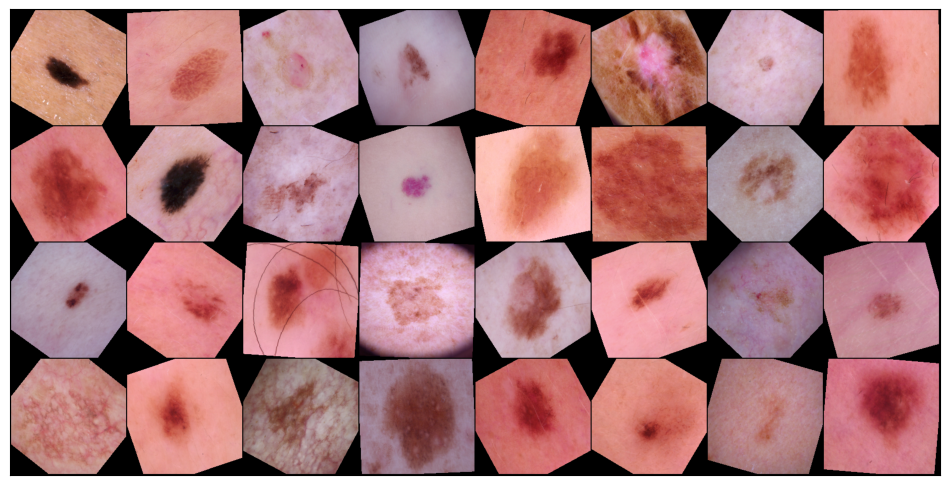

In [ ]:
show_batch(train_loader)

## **ResNet18 Model**

In [ ]:

model = models.resnet18(pretrained=True)
# # Freeze the layers of the ResNet18 model
for param in model.parameters():
    param.requires_grad = False

# Modify the last layer of the model
num_classes = 7 # replace with the number of classes in your dataset
num_features = model.fc.in_features
# Replace the model's classifier
model.fc = nn.Sequential(
    nn.Linear(num_features, 512),  # Use the correct in_features
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(512, num_classes)
)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:01<00:00, 41.8MB/s]


In [ ]:
# Move the model to the GPU if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

In [ ]:
# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [ ]:
# Set the random seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

In [ ]:
#### Train model
import time
train_loss=[]
train_accuary=[]
val_loss=[]
val_accuary=[]

num_epochs = 30  #(set no of epochs)
start_time = time.time() #(for showing time)
# Start loop
for epoch in range(num_epochs): #(loop for every epoch)
    print("Epoch {} running".format(epoch)) #(printing message)
    """ Training Phase """
    model.train()    #(training model)
    running_loss = 0.   #(set loss 0)
    running_corrects = 0
    # load a batch data of images
    for i, (inputs, labels) in enumerate(train_loader):
        inputs = inputs.to(device)
        labels = labels.to(device)
        # forward inputs and get output
        optimizer.zero_grad()
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)
        # get loss value and update the network weights
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        running_corrects += torch.sum(preds == labels.data).item()
    epoch_loss = running_loss / len(train_dataset)
    epoch_acc = running_corrects / len(train_dataset) * 100.
    # Append result
    train_loss.append(epoch_loss)
    train_accuary.append(epoch_acc)
    # Print progress
    print('[Train #{}] Loss: {:.4f} Acc: {:.4f}% Time: {:.4f}s'.format(epoch+1, epoch_loss, epoch_acc, time.time() -start_time))
    """ Validation Phase """
    model.eval()
    with torch.no_grad():
        running_loss = 0.
        running_corrects = 0
        for inputs, labels in val_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            running_corrects += torch.sum(preds == labels.data).item()
        epoch_loss = running_loss / len(val_dataset)
        epoch_acc = running_corrects / len(val_dataset) * 100.
        # Append result
        val_loss.append(epoch_loss)
        val_accuary.append(epoch_acc)
        # Print progress
        print('[Validation #{}] Loss: {:.4f} Acc: {:.4f}% Time: {:.4f}s'.format(epoch+1, epoch_loss, epoch_acc, time.time()- start_time))

Epoch 0 running
[Train #1] Loss: 0.0285 Acc: 69.1377% Time: 96.0635s
[Validation #1] Loss: 0.0348 Acc: 80.0000% Time: 96.4900s
Epoch 1 running
[Train #2] Loss: 0.0254 Acc: 71.2717% Time: 191.5228s
[Validation #2] Loss: 0.0296 Acc: 75.0000% Time: 192.1316s
Epoch 2 running
[Train #3] Loss: 0.0242 Acc: 72.3574% Time: 283.2191s
[Validation #3] Loss: 0.0395 Acc: 70.0000% Time: 283.6863s
Epoch 3 running
[Train #4] Loss: 0.0238 Acc: 72.8816% Time: 376.5267s
[Validation #4] Loss: 0.0376 Acc: 75.0000% Time: 376.9333s
Epoch 4 running
[Train #5] Loss: 0.0237 Acc: 72.6944% Time: 470.4517s
[Validation #5] Loss: 0.0273 Acc: 82.5000% Time: 470.8681s
Epoch 5 running
[Train #6] Loss: 0.0230 Acc: 73.5180% Time: 563.8396s
[Validation #6] Loss: 0.0272 Acc: 75.0000% Time: 564.4945s
Epoch 6 running
[Train #7] Loss: 0.0229 Acc: 73.7052% Time: 655.6329s
[Validation #7] Loss: 0.0269 Acc: 77.5000% Time: 656.0270s
Epoch 7 running
[Train #8] Loss: 0.0224 Acc: 74.5663% Time: 749.1866s
[Validation #8] Loss: 0.0330 

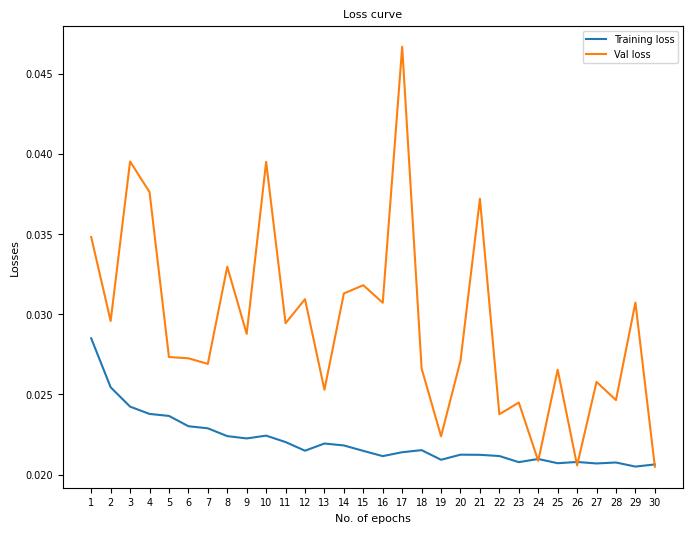

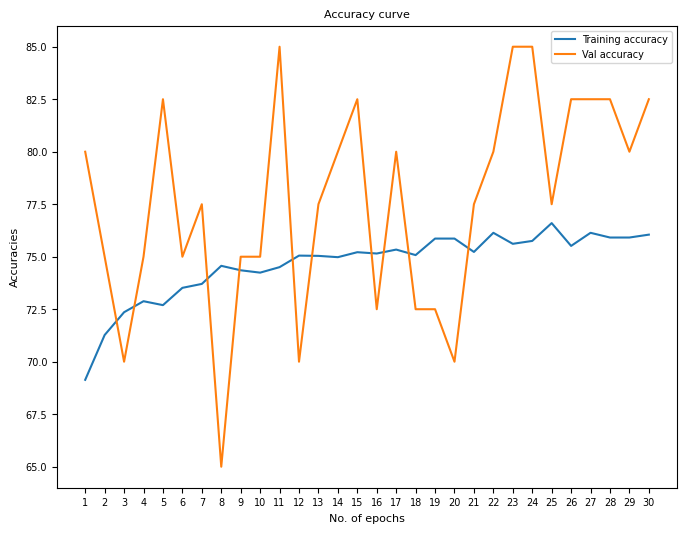

In [ ]:
N = np.arange(num_epochs) + 1

plt.figure(figsize=(8, 6))

# fig.add_subplot(1, 2, 1)
plt.plot(N, train_loss,  label='Training loss')
plt.plot(N, val_loss, label='Val loss')
plt.title('Loss curve', fontsize=8)
plt.xlabel('No. of epochs', fontsize=8)
plt.ylabel('Losses', fontsize=8)
plt.xticks(N, fontsize=7)
plt.yticks(fontsize=7)
plt.legend(fontsize=7)


plt.figure(figsize=(8, 6))
# fig.add_subplot(1, 2, 2)
plt.plot(N, train_accuary,  label='Training accuracy')
plt.plot(N, val_accuary,   label='Val accuracy')
plt.title('Accuracy curve', fontsize=8)
plt.xlabel('No. of epochs', fontsize=8)
plt.ylabel('Accuracies', fontsize=8)
plt.xticks(N, fontsize=7)
plt.yticks(fontsize=7)
plt.legend(fontsize=7);

## save our trained model for testing and future use.

In [ ]:
save_path = 'custom-classifier_resnet_18_final.pth'
torch.save(model.state_dict(), save_path)

In [ ]:
model.eval()
test_running_loss = 0.0
test_running_correct = 0
for int, data in enumerate(test_loader):
    data, target = data[0].to(device), data[1].to(device)
    output = model(data)
    loss = criterion(output, target)
    test_running_loss += loss.item()
    _, preds = torch.max(output.data, 1)
    test_running_correct += (preds == target).sum().item()
    # print("val >>>>>>>>")
    test_loss = test_running_loss/len(test_loader.dataset)
test_accuracy = 100. * test_running_correct/len(test_loader.dataset)
print(f'test_loss: {test_loss:.4f}, test_accuracy: {test_accuracy:.2f}')

test_loss: 0.0237, test_accuracy: 72.62


In [ ]:
# Get data to check on the performance of each label
y_pred = []
y_true = []

num_epochs = 30   #(set no of epochs)
start_time = time.time() #(for showing time)
# Start loop
for epoch in range(num_epochs): #(loop for every epoch)
    model.eval()
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs) # Feed Network
            outputs = (torch.max(torch.exp(outputs), 1)[1]).data.cpu().numpy()
            y_pred.extend(outputs) # Save Prediction
            labels = labels.data.cpu().numpy()
            y_true.extend(labels) # Save Truth

Accuracy on Training set:  0.7195326278659612
Confusion matrix: 
 [[ 1715  2352   169   432   434     3    25]
 [  411 25683   316   134   607    15   104]
 [  209   693  1224   421   227     3    13]
 [   32   185   136   825   112     0     0]
 [  752  2392   364   328  2644     7    23]
 [   36   810   110   139    61   128    36]
 [   47   326   124    62    57    15   419]]
Classification report: 
               precision    recall  f1-score   support

           0       0.54      0.33      0.41      5130
           1       0.79      0.94      0.86     27270
           2       0.50      0.44      0.47      2790
           3       0.35      0.64      0.45      1290
           4       0.64      0.41      0.50      6510
           5       0.75      0.10      0.17      1320
           6       0.68      0.40      0.50      1050

    accuracy                           0.72     45360
   macro avg       0.61      0.47      0.48     45360
weighted avg       0.71      0.72      0.69     453

<Axes: title={'center': 'Confusion matrix for Skin Cancer classification '}>

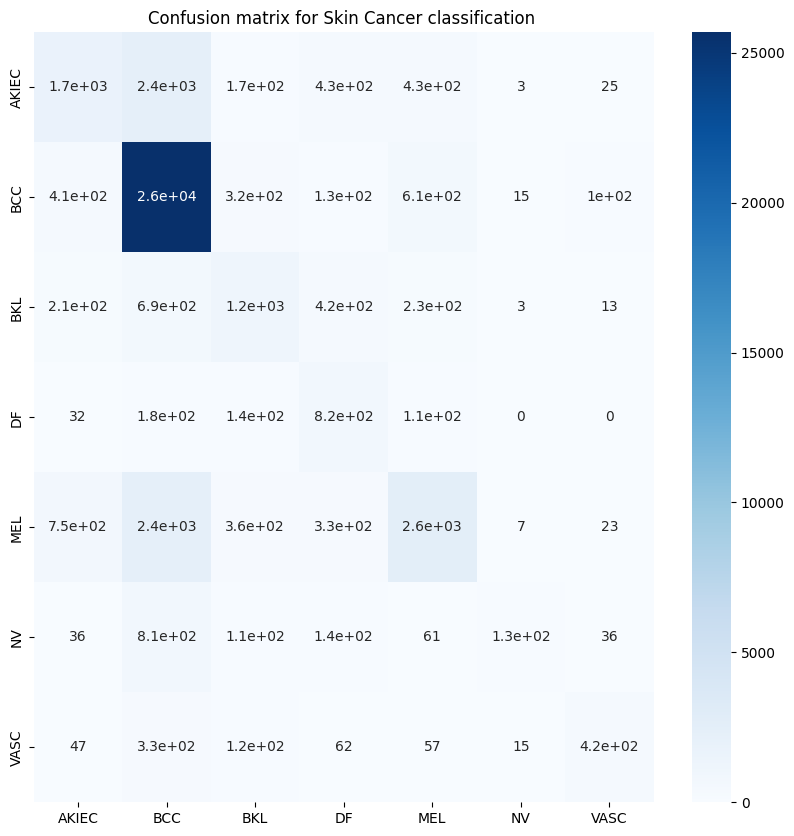

In [ ]:
# Visualization and result
# constant for classes
import seaborn as sn
classes= np.unique(test_df['label'])
# classes = test_dataset.classes
# Build confusion matrix
print("Accuracy on Training set: ",accuracy_score(y_true, y_pred))
print('Confusion matrix: \n', confusion_matrix(y_true, y_pred))
print('Classification report: \n', classification_report(y_true, y_pred))
# Plot
cf_matrix = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(cf_matrix, index = [i for i in classes], columns = [i for i in classes])
plt.figure(figsize = (10,10))
plt.title("Confusion matrix for Skin Cancer classification ")
sn.heatmap(df_cm, annot=True, cmap='Blues')

################################################## 1st model ends here ############################

################################### 2nd model starts here #########################################

In [ ]:
model = models.vgg16(weights=models.VGG16_Weights.IMAGENET1K_V1)

# Freeze all the parameters in the feature extraction layers
for param in model.parameters():
    param.requires_grad = False

model.avgpool = nn.AdaptiveAvgPool2d(output_size=(2, 2))
# Reconstruct the classifier with new layers
# Since the output of avgpool is [batch_size, 512, 2, 2], we have 512 * 2 * 2 = 2048 features
model.classifier = nn.Sequential(
    nn.Linear(in_features=2048, out_features=1024),  # First linear layer
    nn.ReLU(inplace=True),  # Activation function
    nn.Dropout(p=0.5),  # Dropout to prevent overfitting
    nn.Linear(in_features=1024, out_features=512),  # Second linear layer
    nn.ReLU(inplace=True),  # Activation function
    nn.Dropout(p=0.5),  # Dropout to prevent overfitting
    nn.Linear(in_features=512, out_features=7)  # Final layer for 7 output classes
)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:08<00:00, 66.8MB/s]


In [ ]:
def training_batch(data, labels, model, criterion, optimizer):
    model.train()
    data = data.to(device)
    labels = labels.to(device)
    output = model(data)
    loss = criterion(output, labels)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    return loss

In [ ]:
with torch.inference_mode():
  def test_batch(data, labels, model, criterion):
      model.eval()
      data = data.to(device)
      labels = labels.to(device)
      output = model(data)
      loss = criterion(output, labels)
      return loss

In [ ]:
with torch.inference_mode():
  def accuracy(data, labels, model):
      model.eval()
      data = data.to(device)
      labels = labels.to(device)
      output = model(data)
      _, pred_labels = output.max(-1)
      correct = (pred_labels == labels)
      return correct.cpu().detach().numpy().tolist()

In [ ]:
# Move the model to the GPU if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

In [ ]:
model_to_train = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_to_train.parameters(), lr=0.001)

In [ ]:
np.random.seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed(42)

n_epochs = 30

training_loss, test_loss = [], []
training_accuracy, test_accuracy = [], []

for epoch in range(n_epochs):
    training_losses, test_losses = [], []
    training_accuracies, test_accuracies = [], []

    for data, labels in train_loader:
        trng_batch_loss = training_batch(data, labels, model_to_train, criterion, optimizer)
        training_losses.append(trng_batch_loss.item())
        trng_batch_correct = accuracy(data, labels, model_to_train)
        training_accuracies.extend(trng_batch_correct)
    training_per_epoch_loss = np.array(training_losses).mean()
    training_per_epoch_accuracy = np.mean(training_accuracies)

    for data, labels in val_loader:
        tst_batch_loss = test_batch(data, labels, model_to_train, criterion)
        test_losses.append(tst_batch_loss.item())
        tst_batch_correct = accuracy(data, labels, model_to_train)
        test_accuracies.extend(tst_batch_correct)
    test_per_epoch_loss = np.array(test_losses).mean()
    test_per_epoch_accuracy = np.mean(test_accuracies)

    training_loss.append(training_per_epoch_loss)
    training_accuracy.append(training_per_epoch_accuracy)
    test_loss.append(test_per_epoch_loss)
    test_accuracy.append(test_per_epoch_accuracy)

    print(f'Epoch: {epoch+1}/{n_epochs}\t| Training loss: {training_per_epoch_loss:.4f} | ', end='')
    print(f'Training accuracy: {training_per_epoch_accuracy:.4f} | val loss: {test_per_epoch_loss:.4f} | ', end='')
    print(f'val accuracy: {test_per_epoch_accuracy:.4f}')

Epoch: 1/30	| Training loss: 0.9542 | Training accuracy: 0.6969 | val loss: 0.7639 | val accuracy: 0.7250
Epoch: 2/30	| Training loss: 0.8441 | Training accuracy: 0.7206 | val loss: 0.4796 | val accuracy: 0.8250
Epoch: 3/30	| Training loss: 0.8143 | Training accuracy: 0.7363 | val loss: 0.6846 | val accuracy: 0.8250
Epoch: 4/30	| Training loss: 0.7898 | Training accuracy: 0.7460 | val loss: 0.6688 | val accuracy: 0.8250
Epoch: 5/30	| Training loss: 0.7767 | Training accuracy: 0.7518 | val loss: 0.6500 | val accuracy: 0.7750
Epoch: 6/30	| Training loss: 0.7627 | Training accuracy: 0.7497 | val loss: 0.5630 | val accuracy: 0.8250
Epoch: 7/30	| Training loss: 0.7612 | Training accuracy: 0.7576 | val loss: 0.5442 | val accuracy: 0.8250
Epoch: 8/30	| Training loss: 0.7526 | Training accuracy: 0.7626 | val loss: 0.4875 | val accuracy: 0.8250
Epoch: 9/30	| Training loss: 0.7503 | Training accuracy: 0.7641 | val loss: 0.6384 | val accuracy: 0.8500
Epoch: 10/30	| Training loss: 0.7464 | Trainin

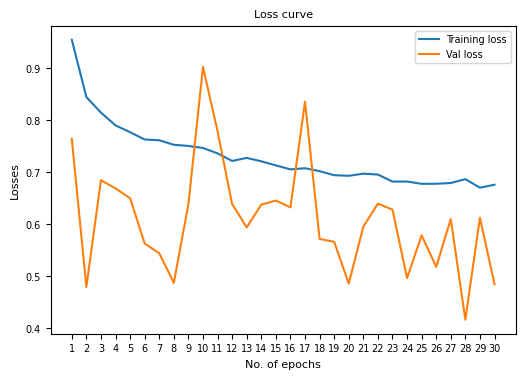

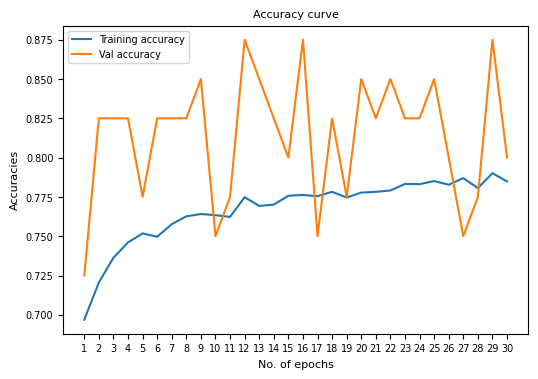

In [ ]:
N = np.arange(n_epochs) + 1

plt.figure(figsize=(6, 4))

# fig.add_subplot(1, 2, 1)
plt.plot(N, training_loss,  label='Training loss')
plt.plot(N, test_loss, label='Val loss')
plt.title('Loss curve', fontsize=8)
plt.xlabel('No. of epochs', fontsize=8)
plt.ylabel('Losses', fontsize=8)
plt.xticks(N, fontsize=7)
plt.yticks(fontsize=7)
plt.legend(fontsize=7)


plt.figure(figsize=(6, 4))
# fig.add_subplot(1, 2, 2)
plt.plot(N, training_accuracy,  label='Training accuracy')
plt.plot(N, test_accuracy,   label='Val accuracy')
plt.title('Accuracy curve', fontsize=8)
plt.xlabel('No. of epochs', fontsize=8)
plt.ylabel('Accuracies', fontsize=8)
plt.xticks(N, fontsize=7)
plt.yticks(fontsize=7)
plt.legend(fontsize=7);

In [ ]:
save_path = 'custom-classifier_vgg16_final.pth'
torch.save(model.state_dict(), save_path)

In [ ]:
model.eval()
test_running_loss = 0.0
test_running_correct = 0
for int, data in enumerate(test_loader):
    data, target = data[0].to(device), data[1].to(device)
    output = model(data)
    loss = criterion(output, target)
    test_running_loss += loss.item()
    _, preds = torch.max(output.data, 1)
    test_running_correct += (preds == target).sum().item()
    # print("val >>>>>>>>")
    test_loss = test_running_loss/len(test_loader.dataset)
test_accuracy = 100. * test_running_correct/len(test_loader.dataset)
print(f'test_loss: {test_loss:.4f}, test_accuracy: {test_accuracy:.2f}')

test_loss: 0.0275, test_accuracy: 70.04


In [ ]:
# Get data to check on the performance of each label
y_pred = []
y_true = []

num_epochs = 30   #(set no of epochs)
start_time = time.time() #(for showing time)
# Start loop
for epoch in range(num_epochs): #(loop for every epoch)
    model.eval()
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs) # Feed Network
            outputs = (torch.max(torch.exp(outputs), 1)[1]).data.cpu().numpy()
            y_pred.extend(outputs) # Save Prediction
            labels = labels.data.cpu().numpy()
            y_true.extend(labels) # Save Truth

Accuracy on Training set:  0.6987874779541446
Confusion matrix: 
 [[ 1452  3160    57   271   181     0     9]
 [  204 26451   256   153   194     0    12]
 [  313   863   863   439   304     0     8]
 [  110   202   143   759    76     0     0]
 [  588  3457   194   377  1886     0     8]
 [   22  1115    38    90    47     0     8]
 [  104   524    62    40    34     0   286]]
Classification report: 
               precision    recall  f1-score   support

           0       0.52      0.28      0.37      5130
           1       0.74      0.97      0.84     27270
           2       0.54      0.31      0.39      2790
           3       0.36      0.59      0.44      1290
           4       0.69      0.29      0.41      6510
           5       0.00      0.00      0.00      1320
           6       0.86      0.27      0.41      1050

    accuracy                           0.70     45360
   macro avg       0.53      0.39      0.41     45360
weighted avg       0.67      0.70      0.65     453

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<Axes: title={'center': 'Confusion matrix for Skin Cancer classification '}>

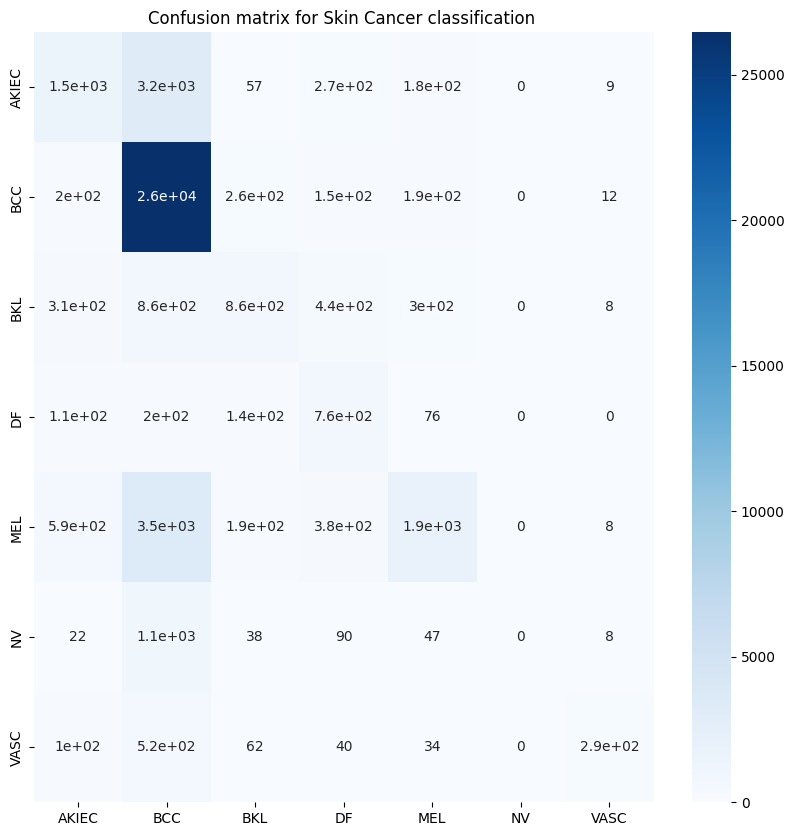

In [ ]:
# Visualization and result
# constant for classes
import seaborn as sn
classes= np.unique(train_df['label'])
# classes = test_dataset.classes
# Build confusion matrix
print("Accuracy on Training set: ",accuracy_score(y_true, y_pred))
print('Confusion matrix: \n', confusion_matrix(y_true, y_pred))
print('Classification report: \n', classification_report(y_true, y_pred))
# Plot
cf_matrix = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(cf_matrix, index = [i for i in classes], columns = [i for i in classes])
plt.figure(figsize = (10,10))
plt.title("Confusion matrix for Skin Cancer classification ")
sn.heatmap(df_cm, annot=True, cmap='Blues')